In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# location of file
FILE_PATH = 'archive/AMZN_2006-01-01_to_2018-01-01.csv'

# Reading the file data
data = pd.read_csv(FILE_PATH)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [3]:
data.tail()

,Date,Open,High,Low,Close,Volume,Name
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
3018,2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


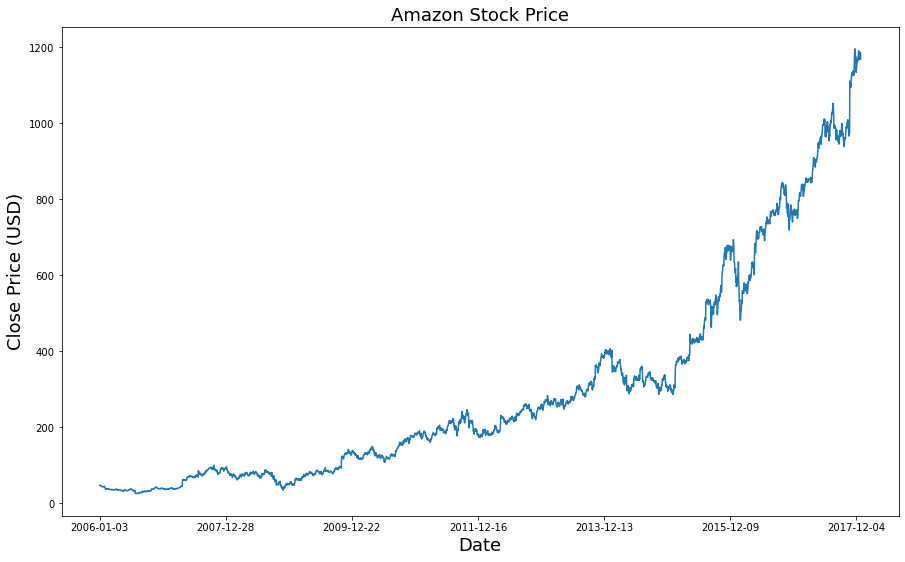

In [107]:
# Plotting the Amazon stock prices

plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500])
plt.title("Amazon Stock Price",fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [5]:
# importing PyTorch
import torch
import torch.nn as nn

# other utility libraries
import time
import copy

We will be using past-n days' closing prices to predict the next day's closing price for the stock

In [6]:
# getting the closing prices for stock

price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


### Data preprocessing

Standardizing the data by scaling the closing prices to be in range of -1 to 1 for better training of the network

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\Ankush\AppData\Local\Temp\ipykernel_33424\68737012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [8]:
def split_data(stock, lookback):
    """
    split_data function takes stock data and returns windowed dataset
    
    Parameters
    ----------
    stock: DataFrame
        input dataframe containing time series univariate data
        
    lookback: int
        window size for previous days
        
    Returns
    -------
    list
    
    x_train: np.array
        training data
    
    y_train: np.array
        training labels

    x_val: np.array
        validation data
        
    y_val: np.array
        validation labels
        
    x_test: np.array
        testing array
    
    y_test: np.array
        testing labels
    """
    lookback += 1 # for 0 indexing
    
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    # 10% data in test set
    test_set_size = int(np.round(0.1*data.shape[0]))
    
    # 20% data in validation set
    val_set_size = int(np.round(0.2*data.shape[0]))
    
    # 70% data in training set
    train_set_size = data.shape[0] - (test_set_size + val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:train_set_size + val_set_size,:-1,:]
    y_val = data[train_set_size:train_set_size + val_set_size,-1,:]
    
    x_test = data[train_set_size + val_set_size:,:-1]
    y_test = data[train_set_size + val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

### Splitting the dataset

In [9]:
# past 10 of days used for prediction of next day's closing price
WINDOW_SIZE = 10

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(price, WINDOW_SIZE)

In [10]:
X_train.shape

(2105, 10, 1)

# Model error metric
Since we are trying to predict the stock price, which is a continuous quantitative variable, we will use Mean squared error (MSE) as an error metric to judge model performance

$$
MSE = \sum_{i=1}^n\frac{(\hat{y_i}-y_i)^2}{n}
$$

where $\hat{y_i}$ is the predicted stock price for $i^{th}$ step and $y_i$ is the actual stock price

# Basline model

#### Naive forecasting

To understand the performance of our model we will be using *naive forecasting* as a baseline metric, which predict the next day's price to be same as previous day's stock price

In [11]:
import sklearn.metrics

def naive_forecasting_MSE(data, labels):
    pred = data[:, -1]
    pred = pd.DataFrame(scaler.inverse_transform(pred))
    labels = pd.DataFrame(scaler.inverse_transform(labels))
    return sklearn.metrics.mean_squared_error(labels, pred)

In [12]:
# training MSE using naive forecasting
naive_forecasting_MSE(X_train, Y_train)

14.619186840855109

In [13]:
# validation MSE using naive forecasting
naive_forecasting_MSE(X_val, Y_val)

95.83188737541535

In [14]:
# testing MSE using naive forecasting
naive_forecasting_MSE(X_test, Y_test)

167.78392325581413

### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [15]:
pred = X_test[:, -1]

In [16]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = Y_test[1:] - Y_test[:-1] > 0

In [17]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc))

0.5466666666666666

#### Moving average forecasting

In [18]:
def moving_avg_forecasting_MSE(data, labels, n=5):
    pred = np.mean(data[:, -n:], axis=1)
    pred = pd.DataFrame(scaler.inverse_transform(pred))
    labels = pd.DataFrame(scaler.inverse_transform(labels))
    return sklearn.metrics.mean_squared_error(labels, pred)

In [19]:
# training MSE using moving average forecasting
moving_avg_forecasting_MSE(X_train, Y_train)

28.87596674204277

In [20]:
# validation MSE using moving average forecasting
moving_avg_forecasting_MSE(X_val, Y_val)

215.7491923654485

In [21]:
# testing MSE using moving average forecasting
moving_avg_forecasting_MSE(X_test, Y_test)

379.8250724784056

### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [22]:
pred = np.mean(X_test[:, -10:], axis=1)

In [23]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = Y_test[1:] - Y_test[:-1] > 0

In [24]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc))

0.52

## General guideline

- Train the model
- Save the model with lowest loss
    - or get correct increase and decreases?
- Testing curve
- Recursive prediction for 10 days in validation/testset

## Vanilla RNN

In [25]:
# converting data to tensors

x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
x_val = torch.from_numpy(X_val).type(torch.Tensor)

y_train = torch.from_numpy(Y_train).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)
y_val = torch.from_numpy(Y_val).type(torch.Tensor)

####  Vanilla RNN model

In [26]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [27]:
# Constants for model instantiation

# input dimension of feature
input_dim = 1

# LSTM hidden dimension
hidden_dim = 32

# Number of LSTM layers
num_layers = 2

# output dimension of network
output_dim = 1

# number of epochs to train the network for
num_epochs = 400

In [28]:
# model instance
model1 = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# loss function
criterion = torch.nn.MSELoss(reduction='mean')

# adam optimizer
optimiser = torch.optim.Adam(model1.parameters(), lr=0.01)

####  Training

In [29]:
hist1 = np.zeros(num_epochs)
start_time = time.time()
val_loss1 = np.zeros(num_epochs)
min_val_loss = float("inf")
optimal_model1 = None

for t in range(num_epochs):
    y_train_pred = model1(x_train)

    loss = criterion(y_train_pred, y_train)
    
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    hist1[t] = loss.item()

    with torch.no_grad():
        pred_val = model1(x_val)
        val_loss1[t] = criterion(pred_val, y_val).item()
        if val_loss1[t] < min_val_loss:
            min_val_loss = val_loss1[t]
            optimal_model1 = copy.deepcopy(model1)
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print(f"Training time: {training_time}")

Epoch  0 MSE:  0.41670745611190796
Epoch  10 MSE:  0.023266443982720375
Epoch  20 MSE:  0.015699416399002075
Epoch  30 MSE:  0.0030702187214046717
Epoch  40 MSE:  0.001167399575933814
Epoch  50 MSE:  0.000399128592107445
Epoch  60 MSE:  0.00026790055562742054
Epoch  70 MSE:  0.00022581835219170898
Epoch  80 MSE:  0.00014345547242555767
Epoch  90 MSE:  0.0001409098185831681
Epoch  100 MSE:  0.0001305204932577908
Epoch  110 MSE:  0.0001222935679834336
Epoch  120 MSE:  0.00011551912757568061
Epoch  130 MSE:  0.00011020514648407698
Epoch  140 MSE:  0.00010581595415715128
Epoch  150 MSE:  0.00010182655387325212
Epoch  160 MSE:  9.821373532759026e-05
Epoch  170 MSE:  9.496000711806118e-05
Epoch  180 MSE:  9.201256034430116e-05
Epoch  190 MSE:  8.934111247071996e-05
Epoch  200 MSE:  8.691662515047938e-05
Epoch  210 MSE:  8.471705223200843e-05
Epoch  220 MSE:  8.272288687294349e-05
Epoch  230 MSE:  8.091715426417068e-05
Epoch  240 MSE:  7.928473496576771e-05
Epoch  250 MSE:  7.781199383316562e

In [30]:
def plot_prices(data, actual_price, model, scaler,
               data_label="Data",
               pred_label="Training Prediction (LSTM)",
               plot_title=''):

#     sns.set_style("darkgrid")    

    # reverse transforming the data
    predict = pd.DataFrame(scaler.inverse_transform(model(data).detach().numpy()))
    original = pd.DataFrame(scaler.inverse_transform(actual_price.detach().numpy()))
    
    # plot
    ax = sns.lineplot(x = original.index, y = original[0], label=data_label, color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label=pred_label, color='tomato')
    ax.set_title(plot_title, size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
#     ax.set_xticklabels('', size=10)

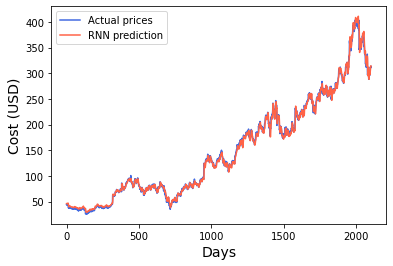

In [31]:
plot_prices(x_train, y_train, optimal_model1, scaler,
           data_label="Actual prices",
           pred_label="RNN prediction")

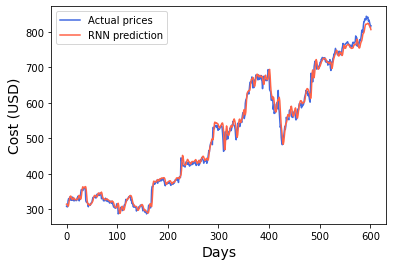

In [32]:
plot_prices(x_val, y_val, optimal_model1, scaler,
           data_label="Actual prices",
           pred_label="RNN prediction")

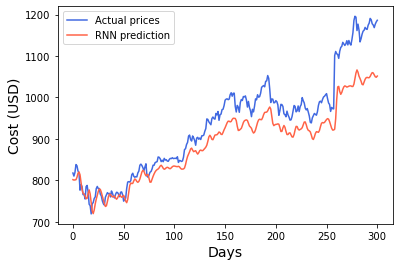

In [33]:
plot_prices(x_test, y_test, optimal_model1, scaler,
           data_label="Actual prices",
           pred_label="RNN prediction")

In [34]:
# training loss plot
def plot_loss(loss):
    ax = sns.lineplot(data=loss, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
#     ax.set_title("Training Loss", size = 14, fontweight='bold')

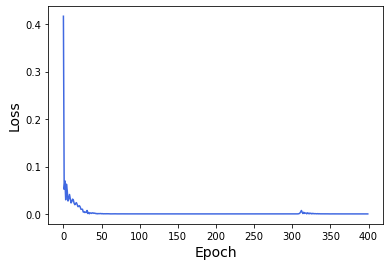

In [35]:
plot_loss(hist1)

In [36]:
def get_MSE(data, labels, model, scaler=scaler):
    predict = pd.DataFrame(scaler.inverse_transform(model(data).detach().numpy()))
    original = pd.DataFrame(scaler.inverse_transform(labels.detach().numpy()))
    
    return sklearn.metrics.mean_squared_error(predict, original)

In [37]:
print("training MSE:", get_MSE(x_train, y_train, model1))
print("validation MSE:", get_MSE(x_val, y_val, model1))
print("testing MSE:", get_MSE(x_test, y_test, model1))

training MSE: 26.797703
validation MSE: 255.51363
testing MSE: 7157.653


### RNN Prediction curve

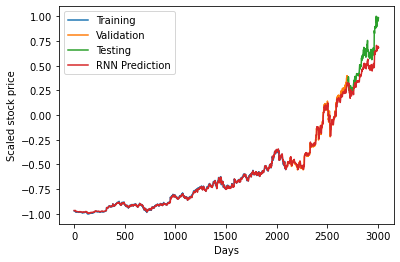

In [38]:
plt.plot(range(len(Y_train)), Y_train, label="Training")
plt.plot(np.arange(len(Y_val)) + len(Y_train) - 1, Y_val, label="Validation")
plt.plot(np.arange(len(Y_test)) + len(Y_train) + len(Y_val) - 1, Y_test, label="Testing")
plt.plot(range(len(torch.concat((y_train, y_val, y_test)))),
         model1(torch.concat((x_train, x_val, x_test))).detach().numpy(), label="RNN Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled stock price")
plt.legend()

### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [39]:
pred = model1(x_test)

In [40]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = y_test[1:] - y_test[:-1] > 0

In [41]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc).detach().numpy())

0.49666666666666665

## LSTM

In [42]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # fully connected layer to produce output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # the hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # the cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # flattening the output for fully connected layer
        out = self.fc(out[:, -1, :]) 
        return out

In [43]:
# Constants for model instantiation

# input dimension of feature
input_dim = 1

# LSTM hidden dimension
hidden_dim = 32

# Number of LSTM layers
num_layers = 2

# output dimension of network
output_dim = 1

# number of epochs to train the network for
num_epochs = 400

In [44]:
# model instance
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# loss function
criterion = torch.nn.MSELoss(reduction='mean')

# adam optimizer
optimiser = torch.optim.Adam(model2.parameters(), lr=0.01)

#### Training

In [45]:
hist2 = np.zeros(num_epochs)
start_time = time.time()
val_loss2 = np.zeros(num_epochs)
min_val_loss = float("inf")
optimal_model2 = None

for t in range(num_epochs):
    y_train_pred = model2(x_train)

    loss = criterion(y_train_pred, y_train)
    
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    hist2[t] = loss.item()

    with torch.no_grad():
        pred_val = model2(x_val)
        val_loss2[t] = criterion(pred_val, y_val).item()
        if val_loss2[t] < min_val_loss:
            min_val_loss = val_loss2[t]
            optimal_model2 = copy.deepcopy(model2)
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print(f"Training time: {training_time}")

Epoch  0 MSE:  0.5776613354682922
Epoch  10 MSE:  0.06622513383626938
Epoch  20 MSE:  0.032384905964136124
Epoch  30 MSE:  0.02645823545753956
Epoch  40 MSE:  0.022780127823352814
Epoch  50 MSE:  0.016926173120737076
Epoch  60 MSE:  0.0045073446817696095
Epoch  70 MSE:  0.0013202574336901307
Epoch  80 MSE:  0.00026027736021205783
Epoch  90 MSE:  0.00018108196672983468
Epoch  100 MSE:  0.00020759554172400385
Epoch  110 MSE:  0.000196967288502492
Epoch  120 MSE:  0.00017585438035894185
Epoch  130 MSE:  0.00016749088536016643
Epoch  140 MSE:  0.00016484156367368996
Epoch  150 MSE:  0.00016173077165149152
Epoch  160 MSE:  0.00015882214938756078
Epoch  170 MSE:  0.00015643796359654516
Epoch  180 MSE:  0.00015414366498589516
Epoch  190 MSE:  0.00015201889618765563
Epoch  200 MSE:  0.00015002829604782164
Epoch  210 MSE:  0.00014815761824138463
Epoch  220 MSE:  0.00014639658911619335
Epoch  230 MSE:  0.00014473425108008087
Epoch  240 MSE:  0.0001431621640222147
Epoch  250 MSE:  0.0001416725135

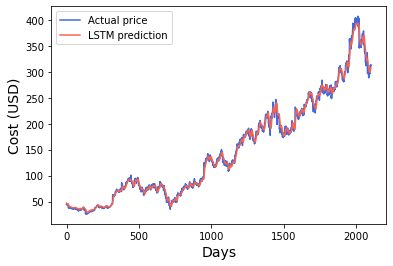

In [46]:
plot_prices(x_train, y_train, optimal_model2, scaler,
           data_label="Actual price",
           pred_label="LSTM prediction")

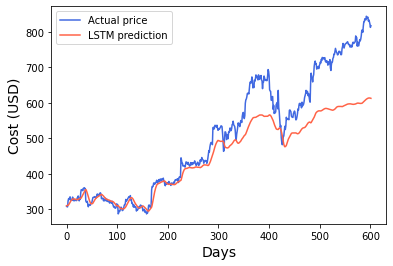

In [47]:
plot_prices(x_val, y_val, optimal_model2, scaler,
           data_label="Actual price",
           pred_label="LSTM prediction")

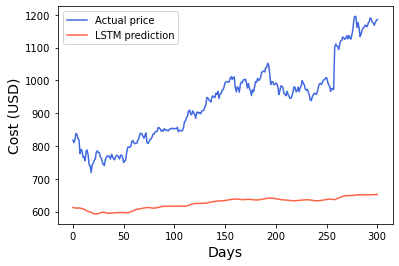

In [48]:
plot_prices(x_test, y_test, optimal_model2, scaler,
           data_label="Actual price",
           pred_label="LSTM prediction")

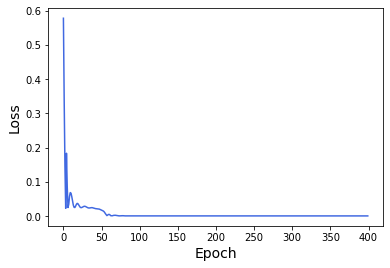

In [49]:
plot_loss(hist2)

In [50]:
print("training MSE:", get_MSE(x_train, y_train, model2))
print("validation MSE:", get_MSE(x_val, y_val, model2))
print("testing MSE:", get_MSE(x_test, y_test, model2))

training MSE: 43.009254
validation MSE: 7110.4204
testing MSE: 106279.07


### LSTM Prediction curve

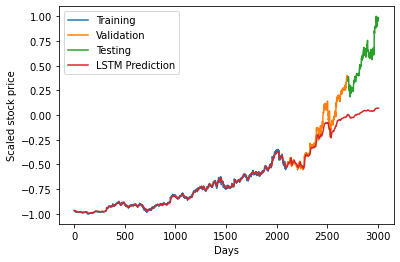

In [51]:
plt.plot(range(len(Y_train)), Y_train, label="Training")
plt.plot(np.arange(len(Y_val)) + len(Y_train) - 1, Y_val, label="Validation")
plt.plot(np.arange(len(Y_test)) + len(Y_train) + len(Y_val) - 1, Y_test, label="Testing")
plt.plot(range(len(torch.concat((y_train, y_val, y_test)))),
         model2(torch.concat((x_train, x_val, x_test))).detach().numpy(), label="LSTM Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled stock price")
plt.legend()

### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [52]:
pred = model2(x_test)

In [53]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = y_test[1:] - y_test[:-1] > 0

In [54]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc).detach().numpy())

0.49666666666666665

## GRU Model

In [55]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [56]:
# Constants for model instantiation

# input dimension of feature
input_dim = 1

# LSTM hidden dimension
hidden_dim = 32

# Number of LSTM layers
num_layers = 2

# output dimension of network
output_dim = 1

# number of epochs to train the network for
num_epochs = 400

In [57]:
# model instance
model3 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# loss function
criterion = torch.nn.MSELoss(reduction='mean')

# adam optimizer
optimiser = torch.optim.Adam(model3.parameters(), lr=0.01)

#### Training

In [58]:
hist3 = np.zeros(num_epochs)
start_time = time.time()
val_loss3 = np.zeros(num_epochs)
min_val_loss = float("inf")
optimal_model3 = None

for t in range(num_epochs):
    y_train_pred = model3(x_train)

    loss = criterion(y_train_pred, y_train)
    
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    hist3[t] = loss.item()

    with torch.no_grad():
        pred_val = model3(x_val)
        val_loss3[t] = criterion(pred_val, y_val).item()
        if val_loss3[t] < min_val_loss:
            min_val_loss = val_loss3[t]
            optimal_model3 = copy.deepcopy(model3)
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print(f"Training time: {training_time}")

Epoch  0 MSE:  0.6001989841461182
Epoch  10 MSE:  0.04032585397362709
Epoch  20 MSE:  0.018053855746984482
Epoch  30 MSE:  0.01156964898109436
Epoch  40 MSE:  0.005162466317415237
Epoch  50 MSE:  0.0003654108732007444
Epoch  60 MSE:  0.00018018271657638252
Epoch  70 MSE:  0.0003435723774600774
Epoch  80 MSE:  0.00017815556202549487
Epoch  90 MSE:  0.00015781514230184257
Epoch  100 MSE:  0.00013568616122938693
Epoch  110 MSE:  0.0001233911607414484
Epoch  120 MSE:  0.00011846635607071221
Epoch  130 MSE:  0.00011432833707658574
Epoch  140 MSE:  0.00011059301323257387
Epoch  150 MSE:  0.00010739301069406793
Epoch  160 MSE:  0.00010446753731230274
Epoch  170 MSE:  0.00010179867967963219
Epoch  180 MSE:  9.935708658304065e-05
Epoch  190 MSE:  9.712012979434803e-05
Epoch  200 MSE:  9.506499191047624e-05
Epoch  210 MSE:  9.317496733274311e-05
Epoch  220 MSE:  9.14344418561086e-05
Epoch  230 MSE:  8.98294456419535e-05
Epoch  240 MSE:  8.834720210870728e-05
Epoch  250 MSE:  8.697624434717e-05
E

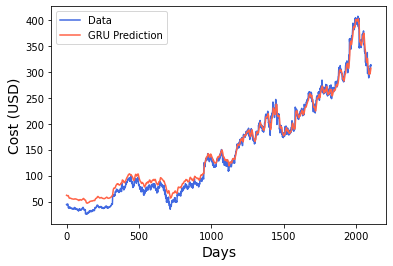

In [59]:
plot_prices(x_train, y_train, optimal_model3, scaler, pred_label="GRU Prediction")

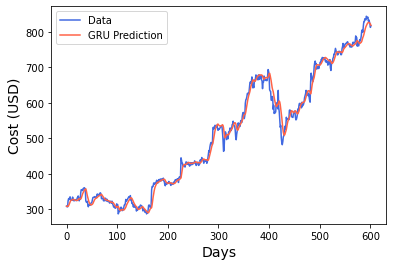

In [60]:
plot_prices(x_val, y_val, optimal_model3, scaler, pred_label="GRU Prediction")

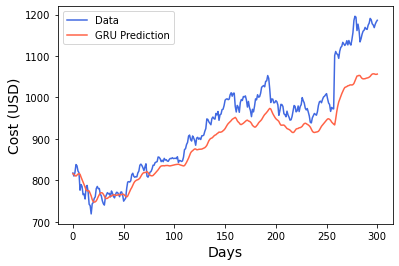

In [61]:
plot_prices(x_test, y_test, optimal_model3, scaler, pred_label="GRU Prediction")

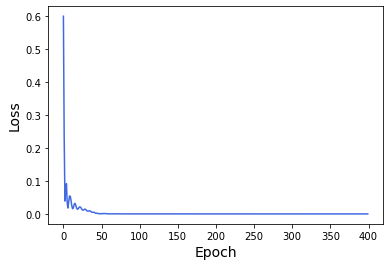

In [62]:
plot_loss(hist3)

In [63]:
print("training MSE:", get_MSE(x_train, y_train, model3))
print("validation MSE:", get_MSE(x_val, y_val, model3))
print("testing MSE:", get_MSE(x_test, y_test, model3))

training MSE: 25.436056
validation MSE: 983.1792
testing MSE: 16242.019


### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [64]:
pred = model3(x_test)

In [65]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = y_test[1:] - y_test[:-1] > 0

In [66]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc).detach().numpy())

0.5166666666666667

In [67]:
def recursive_forecast(last_point, model, forecast_len=10):
    last_point = last_point.clone()
    predictions = []

    for i in range(forecast_len):
        # calculate
        pred = model(last_point)

        # update
        last_point[0, :-1] = last_point[0, 1:].clone()
        last_point[0, -1] = pred.item()

        predictions.append(pred.item())
    return predictions

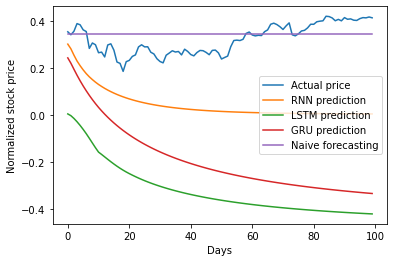

In [68]:
forecast_len = 100
plt.plot(y_test[:forecast_len], label="Actual price")
plt.plot(recursive_forecast(x_val[-1:], model1, forecast_len), label="RNN prediction")
plt.plot(recursive_forecast(x_val[-1:], model2, forecast_len), label="LSTM prediction")
plt.plot(recursive_forecast(x_val[-1:], model3, forecast_len), label="GRU prediction")
plt.plot([x_val[-1, -1].item() for _ in range(forecast_len)], label="Naive forecasting")
plt.ylabel("Normalized stock price")
plt.xlabel("Days")
plt.legend()

### GRU Prediction curve

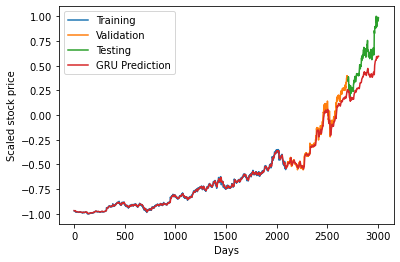

In [69]:
plt.plot(range(len(Y_train)), Y_train, label="Training")
plt.plot(np.arange(len(Y_val)) + len(Y_train) - 1, Y_val, label="Validation")
plt.plot(np.arange(len(Y_test)) + len(Y_train) + len(Y_val) - 1, Y_test, label="Testing")
plt.plot(range(len(torch.concat((y_train, y_val, y_test)))),
         model3(torch.concat((x_train, x_val, x_test))).detach().numpy(), label="GRU Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled stock price")
plt.legend()

## Multivariate model

Using DJIA 30 information technology company closing prices to predict amazon stock price

In [70]:
companies = ["AAPL", "GOOGL", "CSCO", "IBM", "MSFT", "AMZN"]

In [71]:
# location of files
FILE_PATH_AAPL = 'archive/AAPL_2006-01-01_to_2018-01-01.csv'
FILE_PATH_GOOG = 'archive/GOOGL_2006-01-01_to_2018-01-01.csv'
FILE_PATH_CSCO = 'archive/CSCO_2006-01-01_to_2018-01-01.csv'
FILE_PATH_IBM = 'archive/IBM_2006-01-01_to_2018-01-01.csv'
FILE_PATH_MSFT = 'archive/MSFT_2006-01-01_to_2018-01-01.csv'
FILE_PATH_AMZN = 'archive/AMZN_2006-01-01_to_2018-01-01.csv'

In [72]:
def read_stock_data(path):
    data = pd.read_csv(path)
    data = data.sort_values('Date')
    return data

In [73]:
data_aapl = read_stock_data(FILE_PATH_AAPL)
data_goog = read_stock_data(FILE_PATH_GOOG)
data_csco = read_stock_data(FILE_PATH_CSCO)
data_ibm = read_stock_data(FILE_PATH_IBM)
data_msft = read_stock_data(FILE_PATH_MSFT)
data_amzn = read_stock_data(FILE_PATH_AMZN)

Concatenating closing prices for each company

In [74]:
data_comp = pd.DataFrame({"AAPL" : data_aapl["Close"],
                          "GOOG" : data_goog["Close"],
                          "CSCO" : data_csco["Close"],
                          "IBM" : data_ibm["Close"],
                          "MSFT" : data_msft["Close"],
                          "AMZN" : data_amzn["Close"]})
data_comp.head()

,AAPL,GOOG,CSCO,IBM,MSFT,AMZN
0,10.68,217.83,17.45,82.06,26.84,47.58
1,10.71,222.84,17.85,81.95,26.97,47.25
2,10.63,225.85,18.35,82.50,26.99,47.65
3,10.90,233.06,18.77,84.95,26.91,47.87
4,10.86,233.68,19.06,83.73,26.86,47.08


Scaling the dataset

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_aapl = MinMaxScaler(feature_range=(-1, 1))
scaler_goog = MinMaxScaler(feature_range=(-1, 1))
scaler_csco = MinMaxScaler(feature_range=(-1, 1))
scaler_ibm = MinMaxScaler(feature_range=(-1, 1))
scaler_msft = MinMaxScaler(feature_range=(-1, 1))
scaler_amzn = MinMaxScaler(feature_range=(-1, 1))

data_comp["AAPL"] = scaler_aapl.fit_transform(data_comp['AAPL'].values.reshape(-1,1))
data_comp["GOOG"] = scaler_goog.fit_transform(data_comp['GOOG'].values.reshape(-1,1))
data_comp["CSCO"] = scaler_csco.fit_transform(data_comp['CSCO'].values.reshape(-1,1))
data_comp["IBM"] = scaler_ibm.fit_transform(data_comp['IBM'].values.reshape(-1,1))
data_comp["MSFT"] = scaler_msft.fit_transform(data_comp['MSFT'].values.reshape(-1,1))
data_comp["AMZN"] = scaler_amzn.fit_transform(data_comp['AMZN'].values.reshape(-1,1))

In [76]:
# verifying the scaling
data_comp.describe()

,AAPL,GOOG,CSCO,IBM,MSFT,AMZN
count,3019.000000,3019.000000,3019.000000,3020.000000,3019.000000,3019.000000
mean,-0.321162,-0.374228,-0.170411,0.025646,-0.404089,-0.532714
std,0.526498,0.494318,0.400809,0.521024,0.409893,0.478697
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.808724,-0.751621,-0.483678,-0.378245,-0.674059,-0.905929
50%,-0.400875,-0.620953,-0.182325,0.076982,-0.585774,-0.693322
75%,0.090436,-0.075713,0.108678,0.484729,-0.184100,-0.403177
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
def split_data_multiple_reg(stock, lookback):
    lookback += 1
    
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    # 10% data in test set
    test_set_size = int(np.round(0.1*data.shape[0]))
    
    # 20% data in validation set
    val_set_size = int(np.round(0.2*data.shape[0]))
    
    # 70% data in training set
    train_set_size = data.shape[0] - (test_set_size + val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:train_set_size + val_set_size,:-1,:]
    y_val = data[train_set_size:train_set_size + val_set_size,-1,:]
    
    x_test = data[train_set_size + val_set_size:,:-1]
    y_test = data[train_set_size + val_set_size:,-1,:]
    
    # taking only last column for y, as we are prediction one stock
    return [x_train, y_train[:, [-1]], x_val, y_val[:, [-1]], x_test, y_test[:, [-1]]]

In [78]:
# window leanth for each stock
lookback = 10

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_multiple_reg(data_comp, lookback)

In [79]:
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
x_val = torch.from_numpy(X_val).type(torch.Tensor)
y_train = torch.from_numpy(Y_train).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)
y_val = torch.from_numpy(Y_val).type(torch.Tensor)

# Multivariate RNN Model

In [80]:
# for number of predictors
input_dim = 6

hidden_dim = 32
num_layers = 2
output_dim = 1

# number of epochs to train
num_epochs = 400

In [81]:
model4 = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model4.parameters(), lr=0.01)

In [98]:
hist4 = np.zeros(num_epochs)
start_time = time.time()
val_loss4 = np.zeros(num_epochs)
min_val_loss = float("inf")
optimal_model4 = None

for t in range(num_epochs):
    y_train_pred = model4(x_train)

    loss = criterion(y_train_pred, y_train)
    
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    hist4[t] = loss.item()

    with torch.no_grad():
        pred_val = model4(x_val)
        val_loss4[t] = criterion(pred_val, y_val).item()
        if val_loss4[t] < min_val_loss:
            min_val_loss = val_loss4[t]
            optimal_model4 = copy.deepcopy(model4)
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print(f"Training time: {training_time}")

Epoch  0 MSE:  0.00016531716391909868
Epoch  10 MSE:  0.00013566076813731343
Epoch  20 MSE:  0.00010539405047893524
Epoch  30 MSE:  9.744775161379948e-05
Epoch  40 MSE:  9.085518104257062e-05
Epoch  50 MSE:  8.684241765877232e-05
Epoch  60 MSE:  8.406705455854535e-05
Epoch  70 MSE:  8.130479545798153e-05
Epoch  80 MSE:  8.181466546375304e-05
Epoch  90 MSE:  0.0010559646179899573
Epoch  100 MSE:  0.00018669683777261525
Epoch  110 MSE:  0.00024072281667031348
Epoch  120 MSE:  9.529430099064484e-05
Epoch  130 MSE:  0.00010711728100432083
Epoch  140 MSE:  8.319202606799081e-05
Epoch  150 MSE:  8.099788101390004e-05
Epoch  160 MSE:  7.630370964761823e-05
Epoch  170 MSE:  7.475885649910197e-05
Epoch  180 MSE:  8.02814174676314e-05
Epoch  190 MSE:  0.0012789203319698572
Epoch  200 MSE:  0.0002009724557865411
Epoch  210 MSE:  0.00012086748029105365
Epoch  220 MSE:  0.00011297622404526919
Epoch  230 MSE:  8.087424794211984e-05
Epoch  240 MSE:  8.284931391244754e-05
Epoch  250 MSE:  7.5759482569

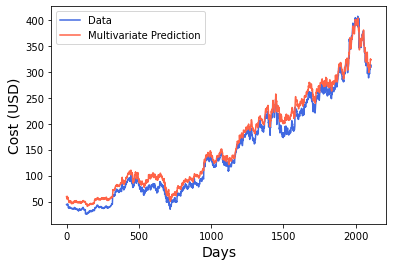

In [99]:
plot_prices(x_train, y_train, optimal_model4, scaler_amzn, pred_label="Multivariate Prediction")

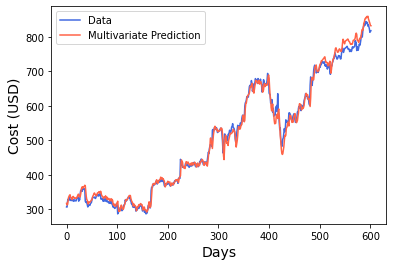

In [100]:
plot_prices(x_val, y_val, optimal_model4, scaler_amzn, pred_label="Multivariate Prediction")

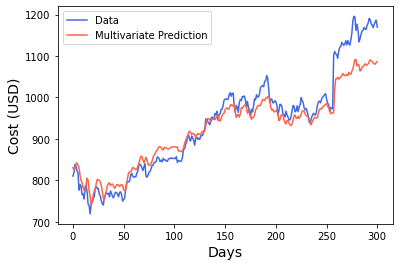

In [101]:
plot_prices(x_test, y_test, optimal_model4, scaler_amzn, pred_label="Multivariate Prediction")

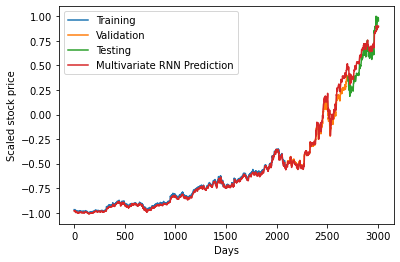

In [102]:
plt.plot(range(len(Y_train)), Y_train, label="Training")
plt.plot(np.arange(len(Y_val)) + len(Y_train) - 1, Y_val, label="Validation")
plt.plot(np.arange(len(Y_test)) + len(Y_train) + len(Y_val) - 1, Y_test, label="Testing")
plt.plot(range(len(torch.concat((y_train, y_val, y_test)))),
         model4(torch.concat((x_train, x_val, x_test))).detach().numpy(), label="Multivariate RNN Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled stock price")
plt.legend()

In [103]:
print("training MSE:", get_MSE(x_train, y_train, model4))
print("validation MSE:", get_MSE(x_val, y_val, model4))
print("testing MSE:", get_MSE(x_test, y_test, model4))

training MSE: 69.1441
validation MSE: 1236.3782
testing MSE: 2600.648


### Profitability of model

For the model to be profitable, we want to be able to predict if the stock price on next day will increase or decrease

In [104]:
pred = model4(x_test)

In [105]:
# predicted increases
pred_inc = pred[1:] - pred[:-1] > 0

# actual increases
actual_inc = y_test[1:] - y_test[:-1] > 0

In [106]:
# proportion of time prediction was correct
np.mean((pred_inc == actual_inc).detach().numpy())

0.5366666666666666

## Loss curves for models

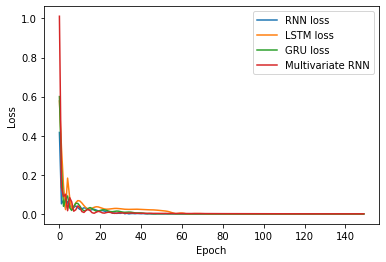

In [91]:
# visiting 150 epochs to better visualize the loss curves
plt.plot(hist1[:150], label="RNN loss")
plt.plot(hist2[:150], label="LSTM loss")
plt.plot(hist3[:150], label="GRU loss")
plt.plot(hist4[:150], label="Multivariate RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()